### Xinlin Ying 001535622


#### let's define some class and function before we answer the question.

#### Bandit Class [1]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
    def __init__(self, arm_count):
        """
        Multi-armed bandit with rewards 1 or 0.
    
        At initialization, multiple arms are created. The probability of each arm
        returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
        chosen from Uniform(0,1) at initialization
        """
        self.arm_count = arm_count
        self.generate_thetas()
        self.timestep = 0
        global stationary
        self.stationary=stationary
    
    def generate_thetas(self):
        self.thetas = np.random.uniform(0,1,self.arm_count)
    
    def get_reward_regret(self, arm):
        """ Returns random reward for arm action. Assumes actions are 0-indexed
        Args:
          arm is an int
        """
        self.timestep += 1
        if (self.stationary==False) and (self.timestep%100 == 0) :
            self.generate_thetas()
    # Simulate bernouilli sampling
        sim = np.random.uniform(0,1,self.arm_count)
        rewards = (sim<self.thetas).astype(int)
        reward = rewards[arm]
        regret = self.thetas.max() - self.thetas[arm]
    
        return reward, regret


#### Thompson Sampling [1]

In [2]:
class BetaAlgo():
    """
    The algos try to learn which Bandit arm is the best to maximize reward.
    It does this by modelling the distribution of the Bandit arms with a Beta, 
    assuming the true probability of success of an arm is Bernouilli distributed.
    """
    def __init__(self, bandit):
        """
        Args:
        bandit: the bandit class the algo is trying to model
        """
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.alpha = np.ones(self.arm_count)
        self.beta = np.ones(self.arm_count)
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
    
    def _update_params(self, arm, reward):
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)
        
    @staticmethod
    def name():
        return 'beta-greedy'
   
    def get_action(self):
        """ Bernouilli parameters are the expected values of the beta"""
        theta = self.alpha / (self.alpha + self.beta)
        return theta.argmax()
class BernThompson(BetaAlgo):
    def __init__(self, bandit):
        super().__init__(bandit)
    @staticmethod
    def name():
        return 'thompson'
  
    def get_action(self):
        """ Bernouilli parameters are sampled from the beta"""
        theta = np.random.beta(self.alpha, self.beta)
        return theta.argmax()


#### E-Greedy [1]

In [3]:
class EpsilonGreedy():
    """
    Epsilon Greedy with incremental update.
    Based on Sutton and Barto pseudo-code, page. 24
    """
    def __init__(self, bandit):
        global epsilon
        self.epsilon = epsilon
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.Q = np.zeros(self.arm_count) # q-value of actions
        self.N = np.zeros(self.arm_count) # action count
        
    @staticmethod
    def name():
        return 'epsilon-greedy'
  
    def get_action(self):
        if np.random.uniform(0,1) > self.epsilon:
            action = self.Q.argmax()
        else:
            action = np.random.randint(0, self.arm_count)
        return action
  
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
  
    def _update_params(self, arm, reward):
        self.N[arm] += 1 # increment action count
        self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
 
  

#### UBC [1]

In [4]:
class UCB():
    """
    Epsilon Greedy with incremental update.
    Based on Sutton and Barto pseudo-code, page. 24
    """
    def __init__(self, bandit):
        global ucb_c
        self.ucb_c = ucb_c
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.Q = np.zeros(self.arm_count) # q-value of actions
        self.N = np.zeros(self.arm_count) + 0.0001 # action count
        self.timestep = 1
  
    @staticmethod
    def name():
        return 'ucb'
    
    def get_action(self):
        ln_timestep = np.log(np.full(self.arm_count, self.timestep))
        confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
        action = np.argmax(self.Q + confidence)
        self.timestep += 1
        return action
    
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
  
    def _update_params(self, arm, reward):
        self.N[arm] += 1 # increment action count
        self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

#### Random Sampling

In [5]:
# by Xinlin Ying
class RandomSampling():
    """
    Random Sampling
    """
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count
    @staticmethod
    def name():
        return 'random-sampling'
  
    def get_action(self):
        action = np.random.randint(0, self.arm_count)
        return action
  
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret

    def _update_params(self, arm, reward):
        return

#### Simulate And Experiment Function

In [36]:
def plot_data(y):
    """ y is a 1D vector """
    x = np.arange(y.size)
    _ = plt.plot(x, y, 'o')

def multi_plot_data(data, names):
    """ data, names are lists of vectors """
    x = np.arange(data[0].size)
    for i, y in enumerate(data):
        plt.plot(x, y, 'o', markersize=2, label=names[i])
    plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
    plt.show()

def simulate(simulations, timesteps, arm_count, Algorithm):
    """ Simulates the algorithm over 'simulations' epochs """
    sum_regrets = np.zeros(timesteps)
    for e in range(simulations):
        bandit = Bandit(arm_count)
        algo = Algorithm(bandit)
        regrets = np.zeros(timesteps)
        for i in range(timesteps):
            action = algo.get_action()
            reward, regret = algo.get_reward_regret(action)
            regrets[i] = regret
        sum_regrets += regrets  
    mean_regrets = sum_regrets / simulations
    return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
    """ 
    Standard setup across all experiments 
    Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
    """
    algos = [EpsilonGreedy, UCB, BernThompson,RandomSampling]
    regrets = []
    names = []
    for algo in algos:
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(algo.name())
    multi_plot_data(regrets, names)

#### Q1:Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important

#### Experiment 1:    
control the arm_count and ucb_c to see the epsilon's effect and epsilon's choice: 0.1,0.2,0.4,0.8

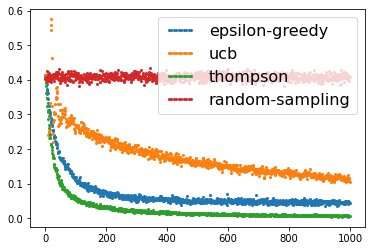

In [37]:
# Experiment 1
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

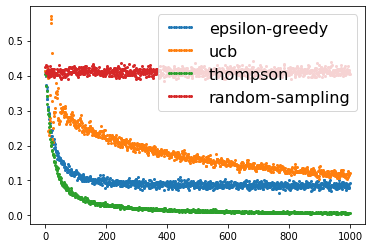

In [38]:
# Experiment 1
arm_count = 10 # number of arms in bandit
epsilon = 0.2
ucb_c = 2
stationary=True
experiment(arm_count)

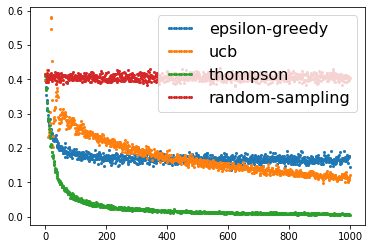

In [39]:
# Experiment 1
arm_count = 10 # number of arms in bandit
epsilon = 0.4
ucb_c = 2
stationary=True
experiment(arm_count)

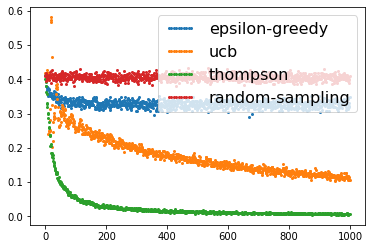

In [40]:
# Experiment 1
arm_count = 10 # number of arms in bandit
epsilon = 0.8
ucb_c = 2
stationary=True
experiment(arm_count)

#### Experiment 2:    
control the arm_count and epsilon to see the ucb_c's effect and ucb_c's choice: 0.5,1,2,4

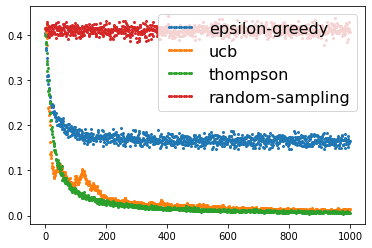

In [41]:
# Experiment 2
arm_count = 10 # number of arms in bandit
epsilon = 0.4
ucb_c = 0.5
stationary=True
experiment(arm_count)

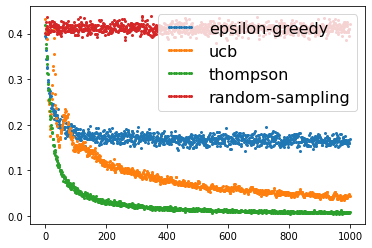

In [42]:
# Experiment 2
arm_count = 10 # number of arms in bandit
epsilon = 0.4
ucb_c = 1
stationary=True
experiment(arm_count)

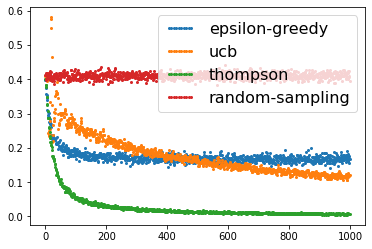

In [43]:
# Experiment 2
arm_count = 10 # number of arms in bandit
epsilon = 0.4
ucb_c = 2
stationary=True
experiment(arm_count)

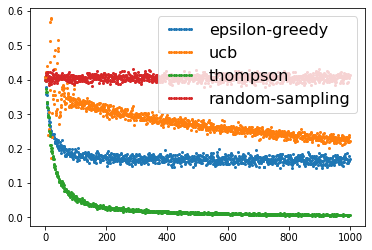

In [44]:
# Experiment 2
arm_count = 10 # number of arms in bandit
epsilon = 0.4
ucb_c = 4
stationary=True
experiment(arm_count)

E-Greedy: eplison is the important hyperparameter.When eplison is larger, the curve is more easy to become stable so it's hard to explore.   
UBC: ucb_c is the important hyperparameter.It's exploring speed slow down as the ucb_c parameter go up.   
Random Sampling &Thompson Sampling:They do not have any hyperparameter.    

#### Q2:How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points)

The Ucb's change frequency become smaller and the highest point and lowest point become larger.The thompson become stable slower. But barely has change on the epsilon-greedy and random sampling.
#### Experiment 3:    
control the epsilon and ucb_c to see the epsilon's effect and arm_count's choice: 50,100,200,400

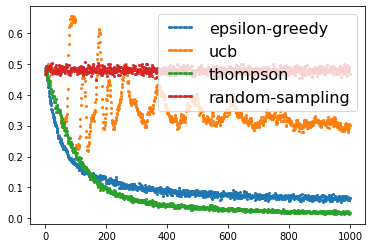

In [45]:
# Experiment 3
arm_count = 50 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

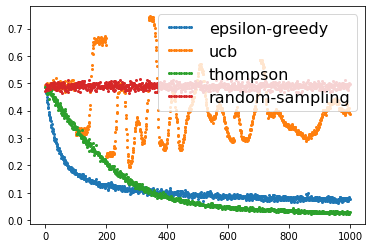

In [46]:
# Experiment 3
arm_count = 100 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

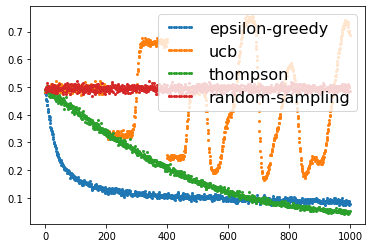

In [47]:
# Experiment 3
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

#### Q3:How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points)
Thompson Sampling: Thompson's regret quickly decreased, on average increase over time. For Staionary situation. It decreased gradually.
E-greedy: E-greedy's regret also quickly decreased and it has a gap every 100 unit.
UCB: Non-stationarity has special emphasis on exploration. So UCB reacts much more quickly and actually continues to improve in regret over time.
Random Sampling:Random Sampling has stable performance.

#### Experiment 4:   
change the stationary is true to false

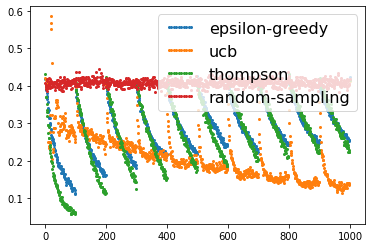

In [48]:
# Experiment 4
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

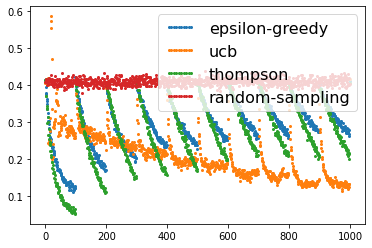

In [49]:
# Experiment 4
arm_count = 10 # number of arms in bandit
epsilon = 0.2
ucb_c = 2
stationary=False
experiment(arm_count)

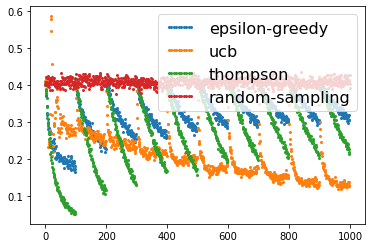

In [50]:
# Experiment 4
arm_count = 10 # number of arms in bandit
epsilon = 0.4
ucb_c = 2
stationary=False
experiment(arm_count)

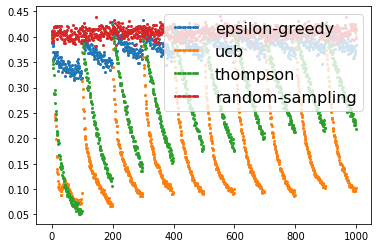

In [51]:
# Experiment 4
arm_count = 10 # number of arms in bandit
epsilon = 0.8
ucb_c = 0.5
stationary=False
experiment(arm_count)

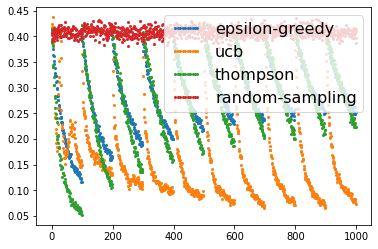

In [52]:
# Experiment 4
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 1
stationary=False
experiment(arm_count)

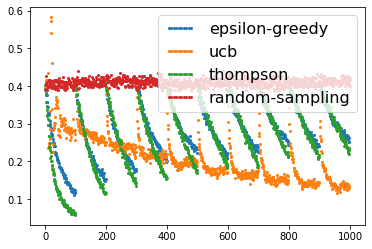

In [53]:
# Experiment 4
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

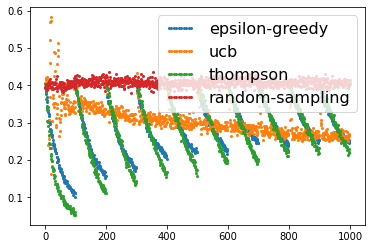

In [54]:
# Experiment 4
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 4
stationary=False
experiment(arm_count)

#### Q4: When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff.
Thompson Sampling, E-greedy, UCB, and Random Sampling will not stop exploring till the simulation is done and they close to 0 infinetly.  
ϵ-greedy, where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring and will keep exploring until the simulation is done.  

After fiddling with ucb_c parameter, we can see that if we set it to 0.1, it quickly converges to a low regret value, and in just a few dozen steps, we can now exceed e-greedy. Note that it outperforms Thompson in the beginning, but not in the long run. Lowering the ucb_c essentially reduces the agent's "premium" for uncertainty. This makes UCB more "greedy", so it converges quickly. But it still didn't surpass Thompson's performance. Given this intuition, we also make e-greedy even more greedy, reducing its hyperparameter to 0.03. We can see that after 1000 steps, it does surpass the previous e-greedy, but only marginally. Also, this comes at the cost of slower convergence. Even as we continued to lower epsilon, we did not observe huge fluctuations in UCB. It is possible that with only 10 actions, greed is a better solution and exploration is expensive and unnecessary, which brings us to the next experiment.[6]

#### Q5: How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer. 
Thompson sampling: Thompson sampling will always remember past actions as it uses the outcome of each action to generate a beta distribution and choose the optimal one with the highest reward.  
E-greedy: E-greedy is the same as Thompson Sampling, it uses previous actions to generate a beta distribution and selects the next best action with the highest reward.  
UCB: UCB also remembers past actions because it chooses the next optimal action by calculating the uncertainty of the action.  
random sampling:Random sampling does not remember past actions. It uses the np.random.randint function to choose actions randomly.  

#### Q6: Thompson Sampling with non-Beta distribution (5 Points) Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc) [2]

In [32]:
import math
class ThompsonNormal():
    def __init__(self, bandit):
        """
        Normal distribution
        """
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        self.mean = np.zeros(self.arm_count)
        self.std = np.zeros(self.arm_count)
        self.n = np.zeros(self.arm_count)
        
    def name():
        return 'thompson-normal'
    
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        self._update_params(arm, reward)
        return reward, regret
    
    def _update_params(self, arm, reward):
        self.n[arm]+=1
        old_mean = self.mean[arm]
        new_mean = (self.mean[arm]*(self.n[arm]-1) + reward)/self.n[arm]
        self.mean[arm] = new_mean

        old_var = np.power(self.std[arm],2)
        if((self.n[arm]-1)!=0):
            new_var = ((self.n[arm]-2)/(self.n[arm]-1))*old_var + (math.pow((reward-old_mean),2))/self.n[arm]
        else:
            new_var = ((self.n[arm]-2))*old_var + (math.pow((reward-old_mean),2))/self.n[arm]
        self.std[arm] = math.sqrt(new_var)
        
    def get_action(self):
        """ Bernouilli parameters are sampled from the beta"""
        theta = np.random.normal(self.mean, self.std)
        return theta.argmax()

In [33]:
def compare_two_thompson(arm_count, timesteps=1000, simulations=1000):
    algos = [BernThompson, ThompsonNormal]
    regrets = []
    names = []
    for algo in algos:
        regrets.append(simulate(simulations, timesteps, arm_count, algo))
        names.append(algo.name())
    multi_plot_data(regrets, names)

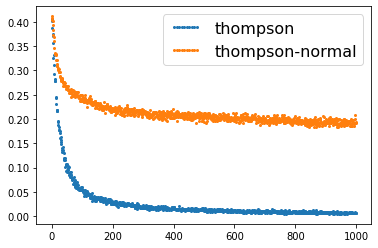

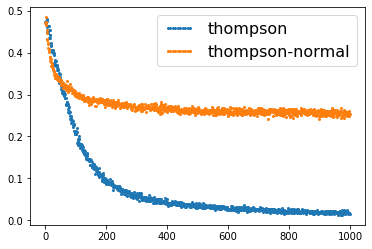

In [34]:
# Experiment 5
arm_count = [10,50] 
epsilon = 0.1
ucb_c = 2
stationary=True
for i in arm_count:
    compare_two_thompson(i)

#### Q7: What code is mine and what have i adapted? Did I explain my code clearly?
In this notebook, I've written the code for Random Sampling based on the existing code and modified experiments which has "By Xinlin Ying" in the first line.And I change the parameters for every experiment to find the result.
The bandits environment, thompson, epsilon greedy and UCB code were cited from reference 1, and implementation of Thompson sampling with normal distribution was referred from reference 2.  

#### Q8：References
[1] Andrecian Flone's code:https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb  
[2] Other's code:https://github.com/davidnallapu/MultiArmedBanditProblem/blob/main/BanditProblems.ipynb  
[3] Multi-armed_bandit wiki:https://en.wikipedia.org/wiki/Multi-armed_bandit  
[4] Pther's code:https://lilianweng.github.io/posts/2018-01-23-multi-armed-bandit/  
[5] Russo, Daniel, Benjamin Van Roy, Abbas Kazerouni, and Ian Osband. "A Tutorial on Thompson Sampling." arXiv preprint   arXiv:1707.02038 (2017).https://arxiv.org/abs/1707.02038  
[6] Other's code:https://tomstafford.staff.shef.ac.uk/?p=48

#### Q9: Licensing
Copyright (c) 2022, Xinlin Ying All rights reserved.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.